# Mol Conversion Notebook

## Imports

In [1]:
import torch_geometric as pyg
from rdkit import Chem
import networkx as nx
import torch
import torch_geometric
import numpy as np

from torch_geometric.utils import from_networkx
import matplotlib.pyplot as plt

import networkx as nx
from rdkit import Chem
from rdkit import Chem

import networkx as nx
import matplotlib.pyplot as plt

## Drawing

In [2]:
def draw_molecules(list_of_smiles, molsPerRow=2):
    from rdkit import Chem
    from rdkit.Chem import Draw

    mols = [Chem.MolFromSmiles(s) for s in list_of_smiles]

    return Draw.MolsToGridImage(mols, molsPerRow=molsPerRow, subImgSize=(150, 150), useSVG=True, maxMols=999999)




In [3]:
def mean_value(vec):
    vec = vec.numpy()
    if np.min(vec) < 0.0:
        vec = vec - np.min(vec)
        
    vec = vec / np.sum(vec)
    mean = np.sum(np.arange(vec.shape[0]) * vec)
    assert mean >= 0
    return mean


def get_neighbors_pyg(g, v_i):
    edge_index = g.edge_index
    neighbors = set(edge_index[1, edge_index[0] == v_i].tolist())
    reverse_neighbors = set(edge_index[0, edge_index[1] == v_i].tolist())
    all_neighbors = neighbors.union(reverse_neighbors)
    return list(all_neighbors)


def pyg_to_reduced_nx(g):
    g_nx = nx.Graph()
    for v_i in range(g.x.shape[0]):
        row = g.x[v_i, :]
        if row[0] > 0.5:
            # is atom
            elem = torch.argmax(row[1:])
            g_nx.add_node(v_i, elem=elem.item())
            
    for v_i in range(g.x.shape[0]):
        row = g.x[v_i, :]
        if row[0] < 0.5:
            # is bond
            bond_type =  torch.argmax(row[6:]) #mean_value(row[6:])  # 
            if bond_type > 0:
                neigs = get_neighbors_pyg(g, v_i)
                assert(len(neigs) == 2)
                g_nx.add_edge(*neigs, bond_type=bond_type.item())
    return g_nx
            

    
    

def elem_to_color(symbol):
    if "float" in str(type(symbol)):
        symbol = round(symbol)  # Round the input in case it is a float
        symbol = atomic_number_to_symbol.get(symbol, 'Unknown')

    cpk_colors = {
        'H': '#FFFFFF',   # Hydrogen (H) - White
        'C': '#808080',   # Carbon (C) - Gray
        'O': '#FF0000',   # Oxygen (O) - Red
        'N': '#0000FF',   # Nitrogen (N) - Blue
        'F': '#FFFF00',   # Fluorine (F) - Yellow
    }

    if symbol in cpk_colors:
        return cpk_colors[symbol]
    else:
        return '#808080'  # Default color for unknown elements (Gray)




def draw_nx_graph(g):
    pos = nx.spring_layout(g)  # Positions for nodes in the graph
    
    for v_i in g.nodes():
        elem = g.nodes[v_i]['elem']
        c = elem_to_color(elem)
        nx.draw_networkx_nodes(g, pos=pos, nodelist=[v_i], node_color=[c])

    for v_i, v_j in g.edges():
        bond_type = g.edges[(v_i, v_j)]['bond_type']
        #bond_type = 2 if bond_type==4 else bond_type
        nx.draw_networkx_edges(g, pos=pos, edgelist=[(v_i, v_j)], width=bond_type*2, alpha=(bond_type+4)/8.0)

    # Draw labels for nodes
    labels = nx.get_node_attributes(g, 'elem')
    nx.draw_networkx_labels(g, pos=pos, labels=labels)

    # Show the graph
    plt.axis('off')
    plt.show()


## Utils

In [4]:
def to_canonical_smiles(smiles):
    """
    Convert a SMILES string to its canonical form.

    Args:
        smiles (str): The SMILES string to convert.

    Returns:
        str: The canonical form of the SMILES string.

    Raises:
        ValueError: If the input SMILES string cannot be converted to a molecule.
    """
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            raise ValueError("SMILES string could not be converted to a molecule.")
        canonical_smiles = Chem.MolToSmiles(mol, isomericSmiles=True)
        return canonical_smiles
    except Exception as e:
        print(f"An error occurred: {e}")

        
def test_to_canonical_smiles():
    """
    Test the to_canonical_smiles function with a specific SMILES string.

    The test_smiles string is passed to the function, and the result is compared 
    to the expected result. If they do not match, the function raises an AssertionError.
    """
    test_smiles = "CN1C=NC2=C1C(=O)N(C(=O)N2C)C"
    result = to_canonical_smiles(test_smiles)
    
    # Insert expected result here. This example assumes the result is the same as the input.
    expected_result = "Cn1c(=O)c2c(ncn2C)n(C)c1=O"  
    
    assert result == expected_result, f"Expected '{expected_result}', but got '{result}'"

test_to_canonical_smiles()


In [5]:
def get_neighbors(data, node_id):
    """
    Retrieve the neighbor nodes of a given node from a PyTorch Geometric data object.

    Args:
        data (torch_geometric.data.Data): A PyTorch Geometric data object representing a graph.
        node_id (int): The ID of the node for which to retrieve neighbors.

    Returns:
        list: A sorted list of unique neighbor node IDs.
    """
    # edge_index tensor has shape [2, num_edges] and type torch.long
    # The first row contains the source nodes, and the second row contains the target nodes
    edge_index = data.edge_index

    # Get the indices of the edges for which the source node is node_id
    source_indices = (edge_index[0] == node_id).nonzero().view(-1)

    # Get the indices of the edges for which the target node is node_id
    target_indices = (edge_index[1] == node_id).nonzero().view(-1)

    # Get the neighbors from the source and target edges
    source_neighbors = edge_index[1, source_indices].tolist()
    target_neighbors = edge_index[0, target_indices].tolist()

    # Combine, remove duplicates, and sort the neighbor lists
    neighbors = sorted(list(set(source_neighbors + target_neighbors)))

    return neighbors


In [6]:
atomic_number_to_symbol = {
    0: 'C',
    1: 'H',
    2: 'O',
    3: 'N',
    4: 'F'
}

def creat_one_hot(symbol):
    vec = [0]*5
    for num, symbol_i in atomic_number_to_symbol.items():
        if symbol_i == symbol:
            vec[num] = 1
    return vec

def test_creat_one_hot():
    assert creat_one_hot('F') == [0, 0, 0, 0, 1]


## Molecule to Nx

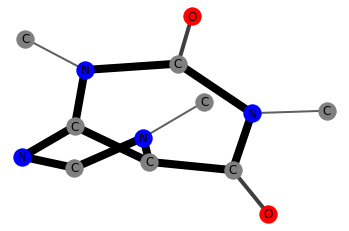

[(0, {'elem': 'C'}), (1, {'elem': 'N'}), (2, {'elem': 'C'}), (3, {'elem': 'N'}), (4, {'elem': 'C'}), (5, {'elem': 'C'}), (6, {'elem': 'C'}), (7, {'elem': 'O'}), (8, {'elem': 'N'}), (9, {'elem': 'C'}), (10, {'elem': 'O'}), (11, {'elem': 'N'}), (12, {'elem': 'C'}), (13, {'elem': 'C'})]


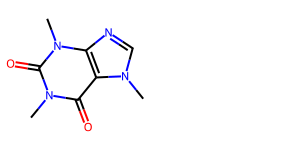

In [7]:
def mol_to_nx(mol):
    """
    Convert a molecule to a networkx graph.

    Args:
        mol (rdkit.Chem.rdchem.Mol): The molecule to convert.

    Returns:
        networkx.Graph: A graph representing the molecule. Each node corresponds to an atom in the molecule and
                        has an 'atom_type' attribute with the chemical symbol of the atom. Each edge corresponds
                        to a bond between atoms and has a 'bond_type' attribute with the bond order (1 for single
                        bonds, 2 for double bonds, 3 for triple bonds, and 4 for aromatic bonds).
    """
    G = nx.Graph()

    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx(), elem=atom.GetSymbol())
    
    for bond in mol.GetBonds():
        bond_type = str(bond.GetBondType())
        bond_order = {"SINGLE": 1, "DOUBLE": 2, "TRIPLE": 3, "AROMATIC": 4}.get(bond_type.upper(), 1)

        G.add_edge(bond.GetBeginAtomIdx(),
                   bond.GetEndAtomIdx(),
                   bond_type=bond_order)
    
    return G

def test_mol_to_nx():
    smiles = "CN1C=NC2=C1C(=O)N(C(=O)N2C)C"
    g = mol_to_nx(Chem.MolFromSmiles(smiles))
    draw_nx_graph(g)
    print(g.nodes(data=True))
    m = draw_molecules([smiles])
    return m
    
    
test_mol_to_nx()

## Smiles to Pyg

In [14]:
def smiles_to_pyg(smiles_mol):
    molecule_rd = Chem.MolFromSmiles(smiles_mol)
    molecule_nx = mol_to_nx(molecule_rd)
    nodes = molecule_nx.nodes(data=True)
    edges = molecule_nx.edges(data=True)
    node_num = len(nodes)
    feature_dim = 1 + 5 + 4 # node or edge +  atom type + edge type

    
    G = nx.Graph() 
    if len(nodes) == 1:
        node_i = nodes[0]
        one_hot_atom_type_i = creat_one_hot(node_i['elem'])
        feature_i = [1] + one_hot_atom_type_i + [-1] * 4
        G.add_node(0, x=feature_i)
    
    for i, node_i in enumerate(nodes):
        for j, node_j in enumerate(nodes):
            if i>=j:
                continue
            assert(node_i[0] == i and node_j[0] == j)
            one_hot_atom_type_i = creat_one_hot(node_i[1]['elem'])
            one_hot_atom_type_j = creat_one_hot(node_j[1]['elem'])
            feature_i = [1] + one_hot_atom_type_i + [-1] * 5
            feature_j = [1] + one_hot_atom_type_j + [-1] * 5
            G.add_node(i, x=feature_i)
            G.add_node(j, x=feature_j)
            
    edges_that_exist = list()

    for node_i, node_j, edge_attr in edges:
        assert(node_i != node_j)
        bond_indicator = [0,0,0,0,0]
        bond_indicator[edge_attr["bond_type"]] = 1
        feature_ij = [0] + [-1] * 5 + bond_indicator
        node_ij = (node_i+1)*100000+(node_j+1)*1000
        G.add_node(node_ij, x=feature_ij)
        edges_that_exist.append(tuple(sorted([node_i, node_j])))
        
        G.add_edge(node_i, node_ij)
        G.add_edge(node_ij, node_j)

    edges_donot_that_exist = list()
    for i, node_i in enumerate(nodes):
        for j, node_j in enumerate(nodes):
            if i == j:
                continue
            edge_ij = tuple(sorted([i, j]))
            if edge_ij in edges_that_exist or edge_ij in edges_donot_that_exist:
                continue
            feature_ij = [0] + [-1] * 5 + [1,0,0,0,0]
            node_ij = (i+1)*100000+(j+1)*1000
            G.add_node(node_ij, x=feature_ij)
            G.add_edge(i, node_ij)
            G.add_edge(j, node_ij)
            edges_donot_that_exist.append(tuple(sorted([i, j])))

    for v_i in G.nodes():
        G.nodes[v_i]['x'] = torch.tensor(G.nodes[v_i]['x'])        

    pyg_graph = from_networkx(G, group_node_attrs=['x'])
    pyg_graph.x = pyg_graph.x.float()
    return pyg_graph
            
def test_smiles_to_pyg():
    smiles_to_pyg('CNC')

## Nx to Mol

In [16]:
def nx_to_mol(G):
    # create empty editable mol object
    mol = Chem.RWMol()

    # add atoms to mol and keep track of index
    node_to_idx = {}
    for i, data in G.nodes(data=True):
        a = Chem.Atom(data['elem'])
        molIdx = mol.AddAtom(a)
        node_to_idx[i] = molIdx

    # add bonds between adjacent atoms
    for i, j, data in G.edges(data=True):
        bond_type = None
        if data['bond_type'] == 0:
            bond_type = None
        elif data['bond_type'] == 1:
            bond_type = Chem.rdchem.BondType.SINGLE
        elif data['bond_type'] == 2:
            bond_type = Chem.rdchem.BondType.DOUBLE
        elif data['bond_type'] == 3:
            bond_type = Chem.rdchem.BondType.TRIPLE
        elif data['bond_type'] == 4:
            bond_type = Chem.rdchem.BondType.AROMATIC
        else:
            assert(False)
        # add more bond types if needed

        if bond_type is not None:
            mol.AddBond(node_to_idx[i], node_to_idx[j], bond_type)

    # Convert RWMol to Mol object
    mol = mol.GetMol()            

    return mol

def test_nx_to_mol():
    g = mol_to_nx(Chem.MolFromSmiles("CN1C=NC2=C1C(=O)N(C(=O)N2C)C"))#
    #Chem.MolFromSmiles("CN1C=NC2=C1C(=O)N(C(=O)N2C)C")
    return nx_to_mol(g)
    #g.edges(data=True)

## Smiles to PyG

In [19]:
def pyg_to_smiles(g):
    g_nx = nx.Graph()
    
    for i in range(g.x.shape[0]):
        row_i = g.x[i,:].flatten()
        if row_i[0] > 0.5:
            atom_type = torch.argmax(row_i[1:6]).item()
            atom_type = atomic_number_to_symbol[atom_type]
            g_nx.add_node(i, elem=atom_type)
            
    for i in range(g.x.shape[0]):
        row_i = g.x[i,:].flatten()
        if row_i[0] > 0.5:
            continue
        neighbors = get_neighbors(g, i)
        assert(len(neighbors) == 2)
        bond_type = torch.argmax(g.x[i,6:]).item()
        if bond_type >= 1:
            g_nx.add_edge(neighbors[0], neighbors[1], bond_type=bond_type)
            
    mol = nx_to_mol(g_nx)
    smiles = Chem.MolToSmiles(mol, isomericSmiles=True)
    try:
        smiles = to_canonical_smiles(smiles)
    except:
        pass
    
    return smiles


def test_all_1():
    g = smiles_to_pyg("CCO")
    print(g)



    smiles_list_in = ["O", "C", "N", "CCO"]
    smiles_list_out = list()
    for s in smiles_list_in:
        smiles_in = to_canonical_smiles(s)
        g = smiles_to_pyg(smiles_in)
        print(g, g.x)
        smiles_out = pyg_to_smiles(g)
        smiles_list_out = smiles_list_out + [smiles_in, smiles_out]


    print(smiles_list_out)
    return draw_molecules(smiles_list_out)

In [22]:
!open .

## Testing

In [20]:
def test_all_2():
    import pandas as pd
    df = pd.read_csv("qm9.csv")

    smiles_list_in = df.smiles[500:700].tolist()
    smiles_list_out = list()
    for s in smiles_list_in:
        smiles_in = to_canonical_smiles(s)
        g = smiles_to_pyg(smiles_in)
        #g.x = g.x + 0.2 * torch.randn_like(g.x)
        #print(g.x)
        smiles_out = pyg_to_smiles(g)
        if smiles_in.lower() != smiles_out.lower():
            print("Warning!:", smiles_in, smiles_out)
            assert(False)
        smiles_list_out = smiles_list_out + [smiles_in, smiles_out]


    print(smiles_list_out)
    svg = draw_molecules(smiles_list_out, molsPerRow=20)
    with open("mol_image.svg", 'w') as f:
        f.write(svg.data)
    return svg